# 학습된 모델 불러와서 테스트하는 코드

In [1]:
import pennylane as qml
from pennylane import numpy as np

from tqdm import tqdm
from IPython.display import clear_output

import torch
from torch.autograd import Variable
from torchvision import datasets, transforms
from functools import reduce
import random
import math
import matplotlib.pyplot as plt
import pickle
import pandas as pd

In [2]:
# 기본 세팅
name1 = "AAPL"
name2 = "TSLA"
cut_left = -0.1
cut_right = 0.1
num_bins = 16
num_dataset = 2000

import yfinance as yf
import datetime

def get_stocks_datas(ticker_names: list[str], start_date, end_date):
    # WARN: returns는 prices보다 길이가 1 작다.
    prices = {}
    returns = {}
    for name in ticker_names:
        data = yf.Ticker(name)
        data = data.history(start=start_date, end=end_date, interval="1d")
        prices[name] = data['Close']
        returns[name] = data['Close'].pct_change()[1:]
    return prices, returns

start_date = datetime.datetime(2011, 1, 1)
end_date = datetime.datetime(2022, 12, 31)
stock_prices, stock_returns = get_stocks_datas([name1, name2], start_date, end_date)

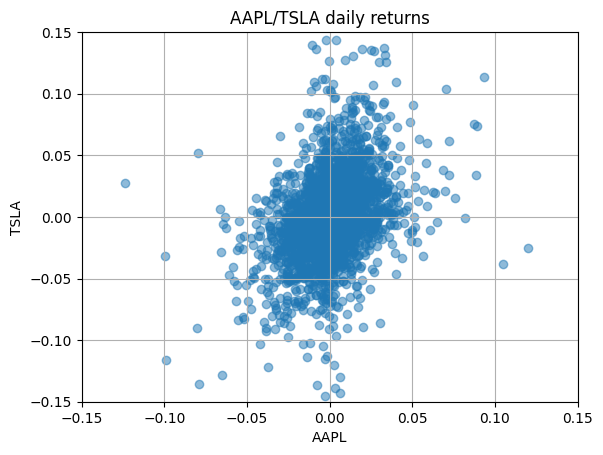

In [3]:
# 산점도 그리기
plt.scatter(stock_returns[name1].values, stock_returns[name2].values, alpha=0.5)
plt.title(f'{name1}/{name2} daily returns')
plt.xlabel(name1)
plt.ylabel(name2)
plt.xlim(-0.15, 0.15)
plt.ylim(-0.15, 0.15)
plt.grid(True)
plt.show()

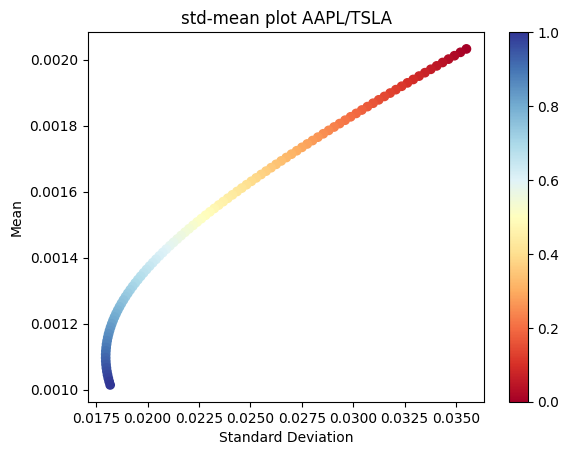

In [4]:
origin_x = []
origin_y = []
origin_c = []
for k in np.linspace(0, 1, 100):
    merged_returns = k * stock_returns[name1].values + (1 - k) * stock_returns[name2].values
    origin_x.append(merged_returns.std())
    origin_y.append(merged_returns.mean())
    origin_c.append(k)

plt.scatter(origin_x, origin_y, c=origin_c, cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Mean')
plt.title(f'std-mean plot {name1}/{name2}')
plt.colorbar()
plt.show()

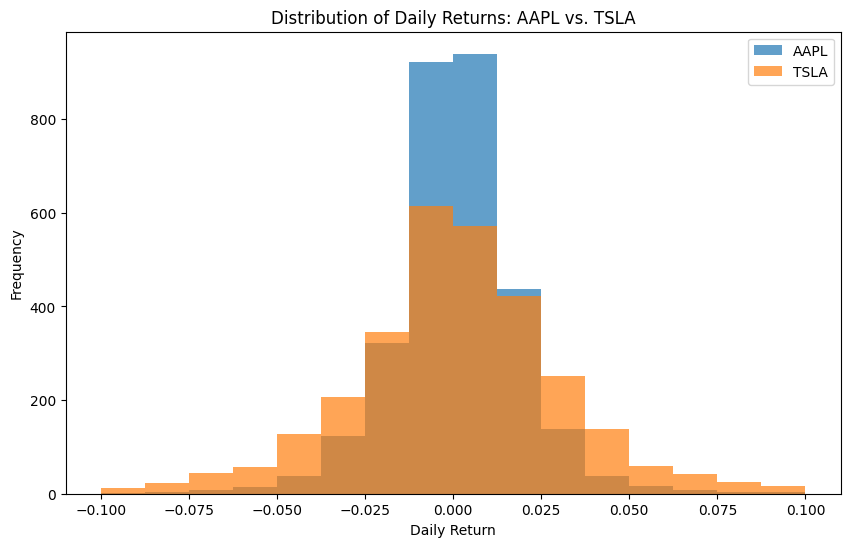

Mean of AAPL: 0.0010
Mean of TSLA: 0.0020


In [5]:
import matplotlib.pyplot as plt
import numpy as np

bin_edges = np.linspace(cut_left, cut_right, num_bins+1)

plt.figure(figsize=(10, 6))

plt.hist(stock_returns[name1].values, bins=bin_edges, alpha=0.7, label=name1)
plt.hist(stock_returns[name2].values, bins=bin_edges, alpha=0.7, label=name2)

plt.title(f'Distribution of Daily Returns: {name1} vs. {name2}')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print(f"Mean of {name1}: {stock_returns[name1].mean():.4f}")
print(f"Mean of {name2}: {stock_returns[name2].mean():.4f}")


In [6]:
stock_prices[name1] = stock_prices[name1] * 10000 / stock_prices[name1].iloc[0]
stock_prices[name2] = stock_prices[name2] * 10000 / stock_prices[name2].iloc[0]

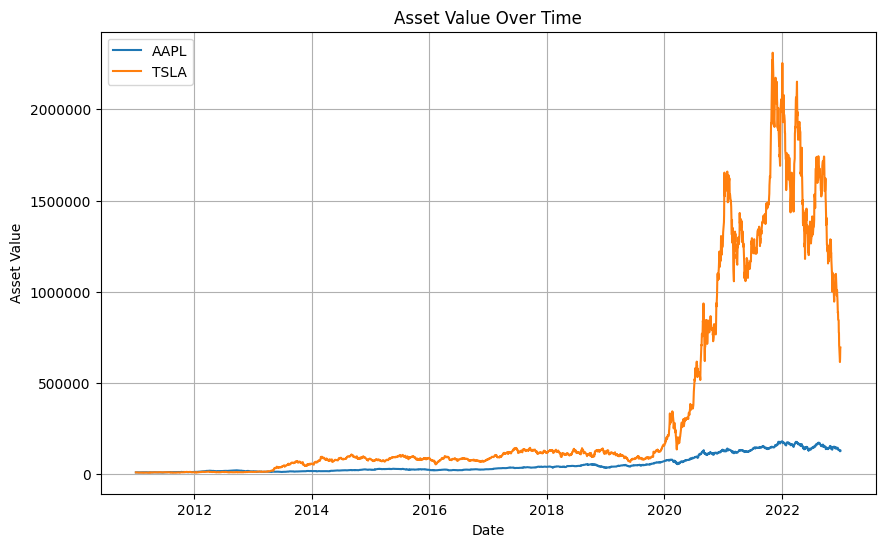

In [7]:

from matplotlib.ticker import FuncFormatter
plt.figure(figsize=(10,6)) # 그래프 크기 설정
plt.plot(stock_prices[name1].index, stock_prices[name1].values,label=name1) # 첫 번째 자산을 그립니다.
plt.plot(stock_prices[name2].index, stock_prices[name2].values,label=name2) # 두 번째 자산을 그립니다.

plt.title('Asset Value Over Time') # 제목 설정
plt.xlabel('Date') # x축 이름 설정
plt.ylabel('Asset Value') # y축 이름 설정
formatter = FuncFormatter(lambda x, pos: '%.f' % (x))
plt.gca().yaxis.set_major_formatter(formatter)

plt.legend() # 범례 표시
plt.grid(True) 
plt.show() 

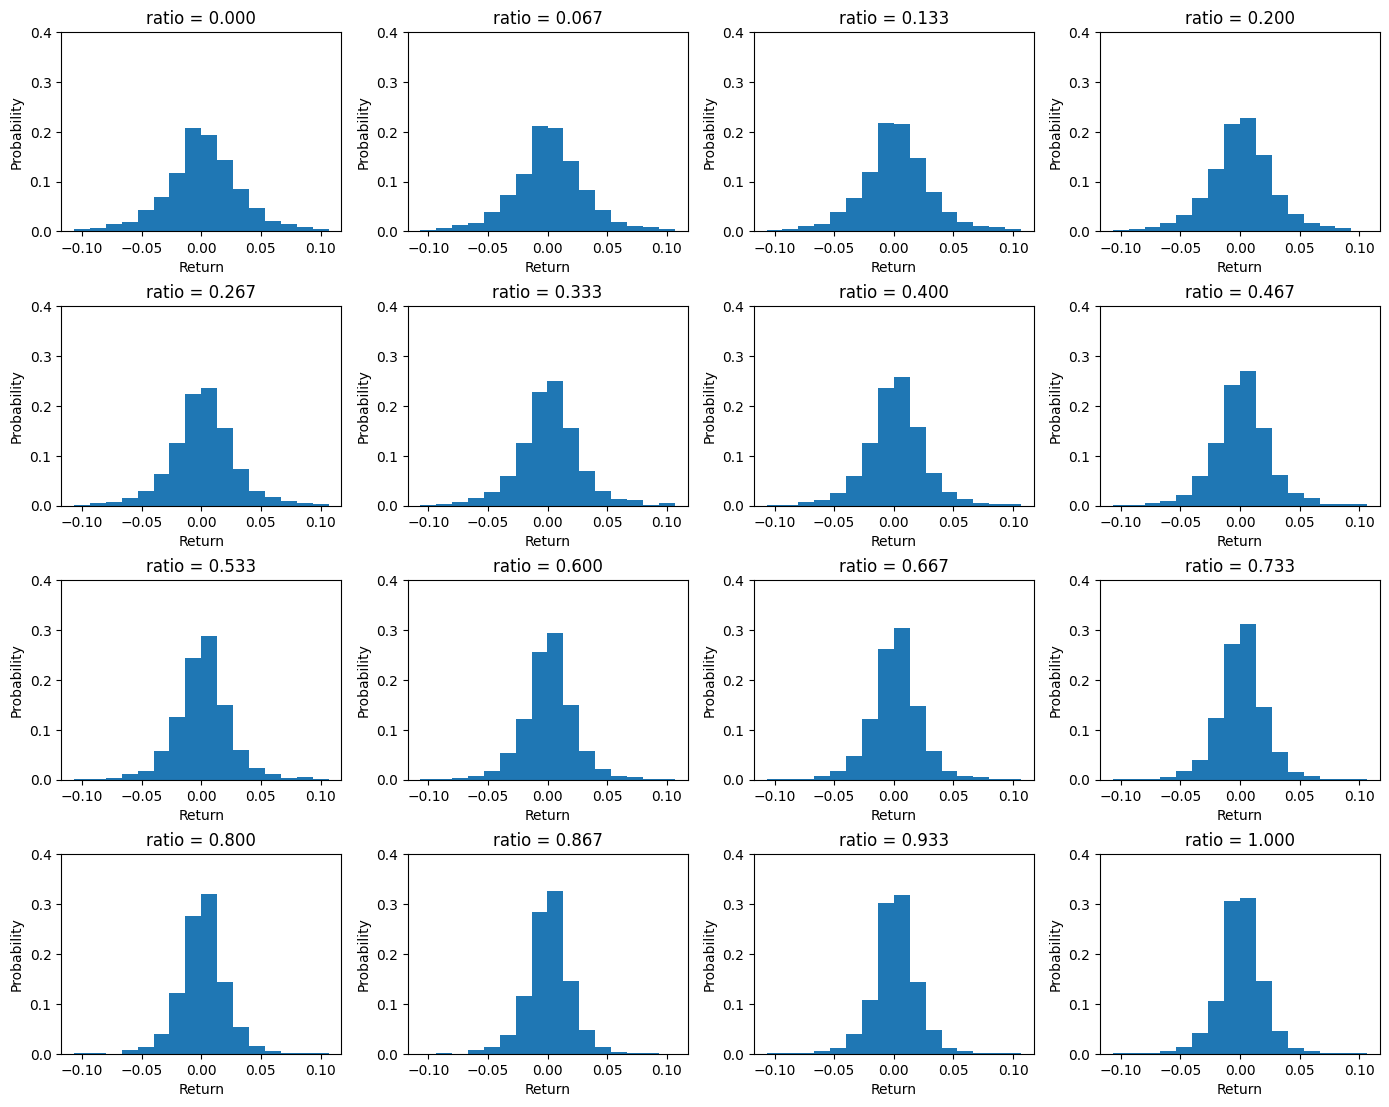

In [8]:
size=4
plt.figure(figsize=(14, 12))
ratios = np.linspace(0, 1, size**2)
for i in range(len(ratios)):
    ratio = ratios[i]
    bins = np.linspace(-0.1, 0.1, num_bins + 1)
    returns = ratio * stock_returns[name1].values + (1 - ratio) * stock_returns[name2].values
    
    hist, _ = np.histogram(returns, bins=bins)
    hist = hist / hist.sum()
    plt.subplot(size, size, i + 1)
    plt.bar(np.linspace(-0.1, 0.1, num_bins), hist, width=0.2*(num_bins+1)/num_bins**2*1.01)
    plt.title(f'ratio = {ratio:.3f}')
    plt.ylim(0, 0.4)
    plt.xlabel('Return')
    plt.ylabel('Probability')
    
    d = (cut_right - cut_left) / num_bins * (num_bins // 2 - 0.5)
    vals = np.linspace(-d, d, num_bins)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [9]:
# setting torch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [10]:
# 이 세팅들은 param.txt에서 참고하자
noise_qubits = 4
code_qubits = 1
output_qubits = 4 # 실제로 출력 상태를 만드는데 쓰이는 개수
n_qubits = 4

n_layers = 5
BATCH_SIZE = 16

print("n_qubits = {} n_layers = {}".format(n_qubits, n_layers))
dev = qml.device("lightning.qubit", wires=n_qubits) # 제너레이터 돌려서 값 뽑아내는데 쓰임. 이중 몇개 골라서 판별자도 학습함.

n_qubits = 4 n_layers = 5


In [11]:
coeff = 0.05

def generator_init(generator_input):
    for i in range(n_qubits):
        qml.RY((generator_input[i]-0.5) * np.pi/4, wires=i)

def generator_layer(params):
    for i in range(n_qubits):
        qml.RY(params[i][0], wires=i)
    for i in range(n_qubits):
        qml.CZ(wires=[i, (i+1)%n_qubits])



@qml.qnode(dev, interface="torch")
def generator_circuit(params, generator_input):
    generator_init(generator_input)
    '''
    for param in params:
        generator_layer(param)
    '''
    for param in params[:n_layers]:
        generator_layer(param)
    for i in range(n_qubits):
        qml.RY(params[n_layers][0], wires=i)

    return qml.probs(wires=range(output_qubits))


def generator_forward(params, generator_input):
    generator_output = [generator_circuit(params, single_in) for single_in in generator_input] # (BATCH_SIZE, 2**output_qubits) 차원
    generator_output = torch.stack(generator_output) # (BATCH_SIZE, 2**output_qubits) 차원
    return generator_output

In [12]:
import torch.nn as nn
from torch.nn import functional as F

class LinearDiscriminator(nn.Module):
    def __init__(self, input_dim=num_bins):
        super().__init__()
        self.hidden_size = 100
        self.input_dim = input_dim
        self.layers = nn.Sequential(
            nn.Linear(num_bins, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, 1),
            nn.Sigmoid())


    def forward(self, x):
        return self.layers(x)

class LinearMine(nn.Module):
    def __init__(self):
        super(LinearMine, self).__init__()
        H = 200
        self.fc1 = nn.Linear(code_qubits, H)
        self.fc2 = nn.Linear(2**output_qubits, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2

In [13]:
generator_params = Variable(torch.tensor(np.random.normal(-np.pi, np.pi, (n_layers, n_qubits, 1))), requires_grad=True)
print("parameter shape: ", generator_params.shape)
discriminator = LinearDiscriminator()

parameter shape:  torch.Size([5, 4, 1])


## 모델 불러오기

In [41]:
import pickle

# title = "final_mine=False_try=6"
title = "final_mine=True_try=6"

# load_epoch = 1086
load_epoch = 450
with open(f'result/{title}/pickles/generator_{load_epoch}.pkl', 'rb') as file:
    generator_params = pickle.load(file)
'''
with open(f'result/{title}/pickles/models_{load_epoch}.pkl', 'rb') as file:
    discriminator, generator_params, mine = pickle.load(file)
'''

"\nwith open(f'result/{title}/pickles/models_{load_epoch}.pkl', 'rb') as file:\n    discriminator, generator_params, mine = pickle.load(file)\n"

In [73]:
def get_averages(codes: list[float], shots=128, code_ind: int = -1):
    returns = []
    for code in tqdm(codes):
        seed = torch.rand((shots, n_qubits))
        seed[:, code_ind] = code
        result = generator_forward(generator_params, seed).detach().numpy()
        returns.append(result.mean(axis=0))
    returns = np.array(returns)
    return returns


def visualize_average(shots=128, size=(4, 4)):
    # 3*3 그래프와 함께 9개점 plot std-mean 그림
    if size == (3, 3):
        plt.figure(figsize=(12, 8))
    elif size == (4, 4):
        plt.figure(figsize=(14, 12))
    elif size == (3, 5):
        plt.figure(figsize=(15, 8))

    x = []
    y = []
    c = []

    codes = np.linspace(0, 1, size[0]*size[1])
    probs_list = get_averages(codes, shots=shots)
    for i in tqdm(range(len(codes))):
        code = codes[i]
        probs = probs_list[i]
        plt.subplot(size[0], size[1], i + 1)
        plt.bar(np.linspace(-0.1, 0.1, num_bins), probs, width=0.2*(num_bins+1)/num_bins**2*1.01)
        plt.title(f'{code:.3f}', fontsize=19)
        plt.tick_params(axis='both', labelsize=14)
        plt.ylim(0, 0.4)
        plt.xlabel('Return', fontsize=17)

        if i % size[1] == 0:
            plt.ylabel('Probability', fontsize=17)
        
        d = (cut_right - cut_left) / num_bins * (num_bins // 2 - 0.5)
        vals = np.linspace(-d, d, num_bins)

        avg = np.sum(probs * vals)
        std = np.sqrt(np.sum(probs * (vals - avg)**2))
        x.append(std)
        y.append(avg)
        c.append(code.item())

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig(f'result/{title}/analize_{load_epoch}_{size[0]}{size[1]}.png', dpi=300)
    plt.show()

    plt.figure(figsize=(6, 6))
    plt.scatter(x, y, c=c, cmap='RdYlBu')
    plt.plot(x, y)
    plt.xlabel('Standard Deviation')
    plt.ylabel('Mean')
    plt.title(f'std-mean plot')
    plt.colorbar()
    plt.savefig(f'result/{title}/analize_{load_epoch}_2.png', dpi=300)
    plt.show()
    return x, y

def visualize_std_mean(codes: list[float], shots=128):
    # std-mean 공간을 plot하기 위한 함수
    probs_list = get_averages(codes, shots=shots)
    x = []
    y = []
    c = []
    for i in tqdm(range(len(codes))):
        code = codes[i]
        probs = probs_list[i]

        d = (cut_right - cut_left) / num_bins * (num_bins // 2 - 0.5)
        vals = np.linspace(-d, d, num_bins)

        avg = np.sum(probs * vals)
        std = np.sqrt(np.sum(probs * (vals - avg)**2))
        x.append(std)
        y.append(avg)
        c.append(code.item())
    
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, c=c, cmap='RdYlBu')
    plt.plot(x, y)
    plt.xlabel('Standard Deviation')
    plt.ylabel('Mean')
    plt.title(f'std-mean plot {name1}/{name2}')
    plt.colorbar()
    plt.savefig(f'result/{title}/analize_{load_epoch}_3({shots}).png', dpi=300)
    plt.show()

def visualize_variables(codes: list[float], shots=128):
    # 모든 노이즈들의 자취를 std-mean 공간에 plot하기 위한 함수
    markerstyles = ['o', '*', '+', 'v', '^']
    linestyles = ['-', '--', '-.', ':', '-']
    labels = [f'noise{i+1}' for i in range(n_qubits)]
    labels[-1] = 'code'

    plt.figure(figsize=(5, 6))
    xs = []
    ys = []
    cs = []
    for v in range(n_qubits):
        probs_list = get_averages(codes, shots=shots, code_ind=v) # 모든 위치를 테스트해봄
        x = []
        y = []
        c = []
        for i in tqdm(range(len(codes))):
            code = codes[i]
            probs = probs_list[i]

            d = (cut_right - cut_left) / num_bins * (num_bins // 2 - 0.5)
            vals = np.linspace(-d, d, num_bins)

            avg = np.sum(probs * vals)
            std = np.sqrt(np.sum(probs * (vals - avg)**2))
            x.append(std)
            y.append(avg)
            c.append(code.item())
    
        plt.scatter(x, y, c=c, cmap='RdYlBu', marker=markerstyles[v])
        plt.plot(x, y, linestyle=linestyles[v], label=labels[v])
        xs.append(x)
        ys.append(y)
        cs.append(c)
    

    plt.scatter(origin_x, origin_y, c=origin_c, cmap='RdYlBu')
    plt.xlabel('Standard Deviation')
    plt.ylabel('Mean')
    plt.legend()
    plt.title(f'std-mean plot of codes {name1}/{name2}')
    plt.colorbar()
    plt.savefig(f'result/{title}/analize_{load_epoch}_4({shots}).png')
    plt.show()
    return xs, ys, cs

100%|██████████| 15/15 [00:00<00:00, 104.59it/s]


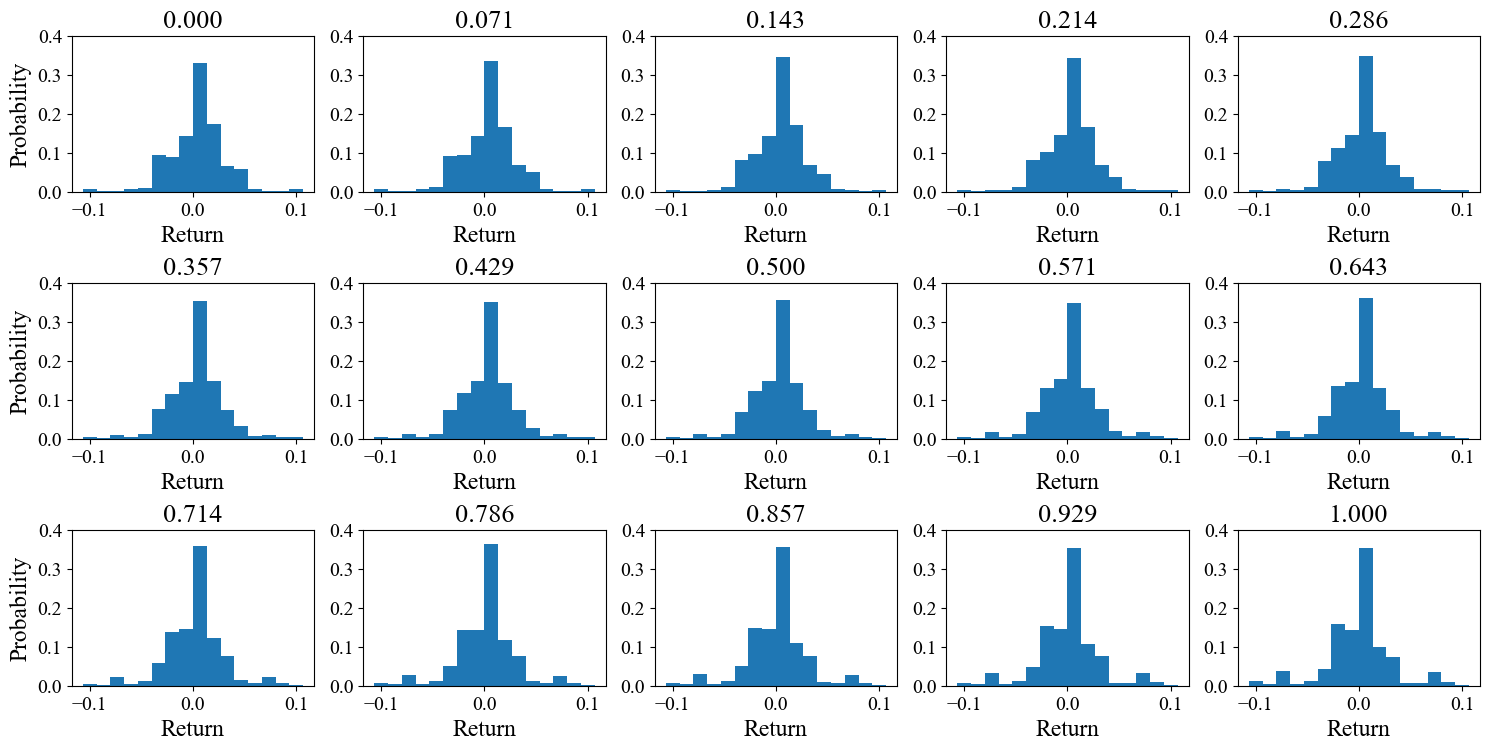

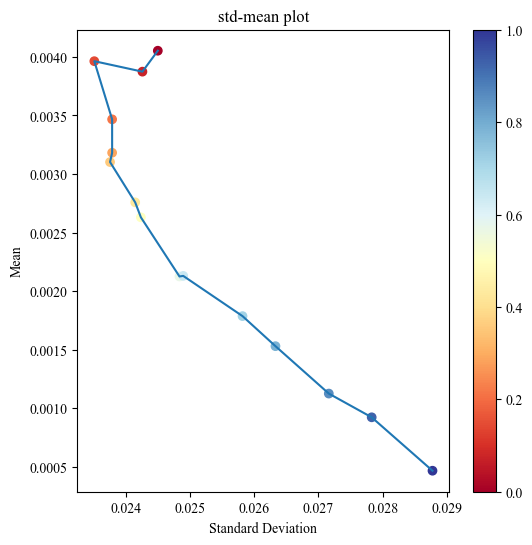

In [74]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
x, y = visualize_average(shots=256, size=(3, 5))

100%|██████████| 20/20 [00:00<00:00, 46942.41it/s]


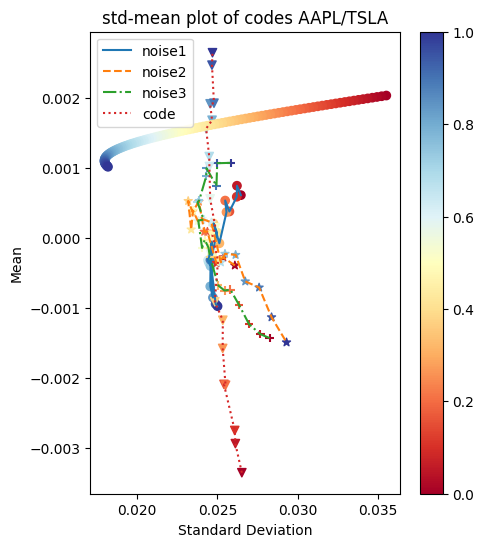

In [361]:
shots = 256
xs, ys, cs = visualize_variables(np.linspace(0, 1, 20), shots=shots)

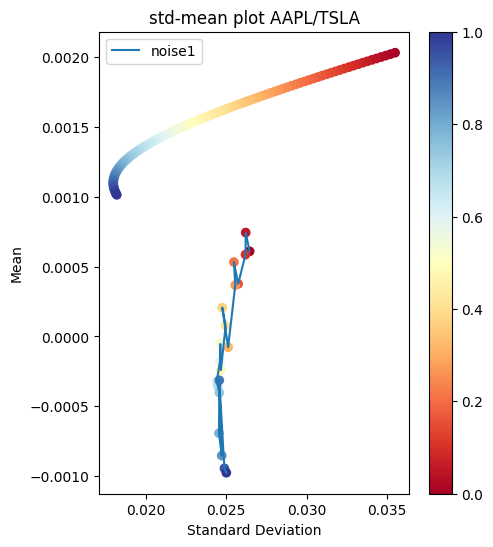

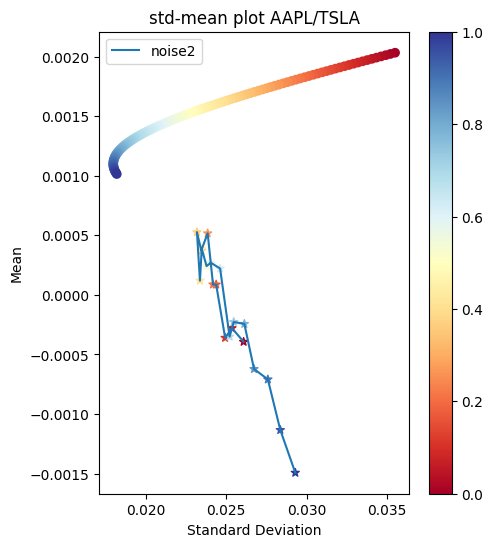

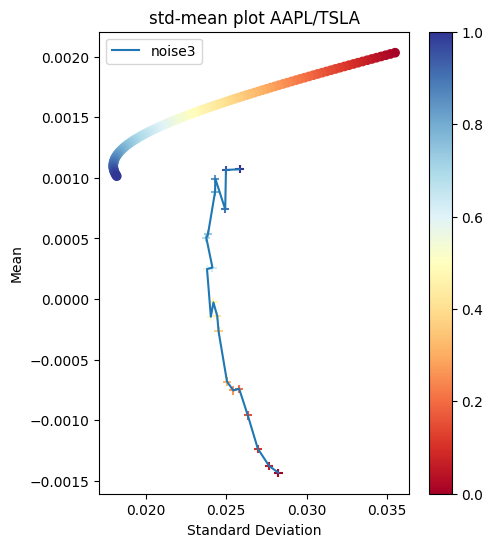

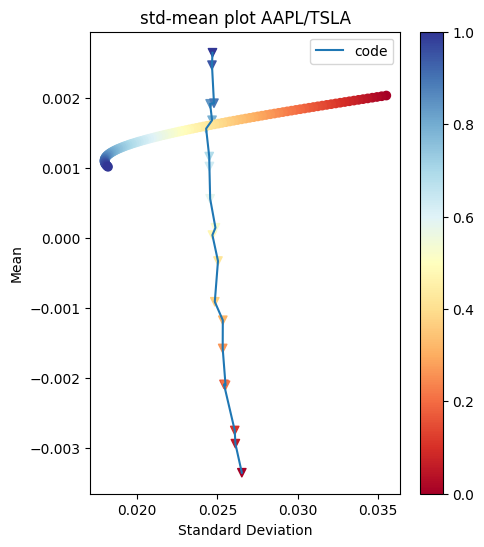

In [363]:
markerstyles = ['o', '*', '+', 'v', '^']
labels = [f'noise{i+1}' for i in range(n_qubits)]
labels[-1] = 'code'

for v in range(n_qubits):
    plt.figure(figsize=(5, 6))
    x = xs[v]
    y = ys[v]
    c = cs[v]

    plt.scatter(x, y, c=c, cmap='RdYlBu', marker=markerstyles[v])
    plt.plot(x, y, label=labels[v])
    xs.append(x)
    ys.append(y)
    cs.append(c)
    
    plt.scatter(origin_x, origin_y, c=origin_c, cmap='RdYlBu')
    plt.xlabel('Standard Deviation')
    plt.ylabel('Mean')
    plt.legend()
    plt.title(f'std-mean plot {name1}/{name2}')
    plt.colorbar()
    plt.savefig(f'result/{title}/analize_{load_epoch}_v{v}({shots}).png')
    plt.show()

In [357]:
nomine_x, nomine_y = x, y

In [364]:
mine_x, mine_y = x, y

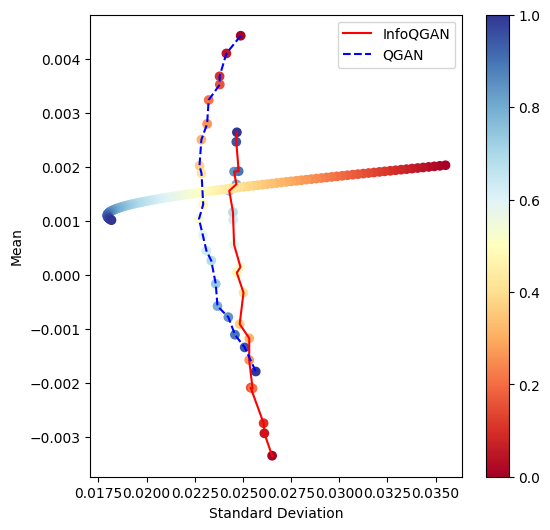

In [366]:
plt.figure(figsize=(6, 6))
plt.scatter(mine_x, mine_y, c=np.linspace(0, 1, 20), cmap='RdYlBu')
plt.scatter(nomine_x, nomine_y, c=np.linspace(0, 1, 20), cmap='RdYlBu')
plt.scatter(origin_x, origin_y, c=origin_c, cmap='RdYlBu')
plt.plot(mine_x, mine_y, c='red', linestyle='-',label='InfoQGAN')
plt.plot(nomine_x, nomine_y, c='blue', linestyle='--', label='QGAN')
plt.xlabel('Standard Deviation')
plt.ylabel('Mean')
plt.colorbar()
plt.legend()
plt.show()